In [44]:
# Uncomment if use Colab
# '''from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True) #mount google drive
# '''

In [365]:
# Nothing better to begin with than by importing some necessary dependencies. 
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from torch.utils import data
import random
import sys
import my_utils as mu
d2l = sys.modules[__name__]

# ECS269U/P - Coursework


* The **goal** of the CW is similar to that of Week 2's Lab: fitting a curve to data, also known as **curve fitting**. 
* This has applications in many different disciplines that make use of AI: FinTech, Physics Modelling, or even Sports. 
* For example, we might be interested in learning the evolution (over time) of the price of a specific product in different countries. This can depend on several factors: the product itself, the country, the initial value of the product's price, etc. 
* As usual, we are interested in learning a model that finds these relationships *from the data*. 


### Learning a family of functions

* The main difference with Week 2's Lab is that we will learn a network that does not learn a single function but a *family of functions*.
* We will consider a family of sinusoidal functions. 
* Below you can find the code generating the data according to different random sinusoidal functions $\{f_a\}$. We randomly generate a set of 40 points in the x-axis in the interval $[-2, 2]$, slightly randomly shifted. Our functions will have the form of $y = f_a(x) = a * sin(x+a)$ where each $a$ will be randomly sampled for each function from interval $[-2, 2]$.  To "draw" a function $f_a$, we first choose some $a \sim U(-2,2)$ and then we compute $f_a$ using the above formula for all the $x$ in the x-axis. 


In [126]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a*torch.sin(x+a)

## The Learning Goal

* Because we are dealing with a family of functions and not just a single function, our model must be able to perform two tasks: *Function Selection* and *Regression*.
* Function selection means that given some *additional* input (to be defined below) the model somehow must choose which function $f_a$ from the family of functions $\{f_a\}$ it needs to model.
* Once the correct function is picked then the model must perform regression i.e. learn the relationship $y=f_a(x)$.




## The Learning Objective

* During training we randomly sample functions from the family of functions $\{f_a\}$. For each $f_a$, we are provided with the (input, output) pairs $(x_t, y_t), t=1,\dots,N_{pts}$.

* To perform *Function Selection*, a **random subset** of $(x_t, y_t), t=1,\dots,N_{pts}$ is provided as auxiliary input to the model during *both training and testing*. These auxiliary data is called the *context data:* $(x_c, y_c), c=1,\dots,N_c$. 

* Note that the total number of context points $N_c$ should be different (and randomly chosen) for every batch so that the model learns to handle different number of context points at test time. This means that the model should be able to work for e.g. $N_c=5$ but also for $N_c=12$ etc.

* Our model will take the context pairs $(x_c, y_c)$ and input values $x_t$ and will produce the estimated values $\hat{y}_t$. 

* During training we have access to the ground-truth values $y_t$, and thus we can compute a loss between the model's predictions $\hat{y}_t$ and the ground-truth values $y_t$.  


## The Model

* Our model will consists of 2 MLPs which must be jointly trained.
* The first MLP is called the *Context Encoder* or Encoder. The Encoder will take as input each pair $(x_c, y_c)$ and will produce a corresponding feature representation $r_c$ of dimension $r_{dim}$.
* A total context feature is produced by averaging over all features: $r_C= \frac{1}{N}\sum_c r_c$.
* The second MLP is called the Decoder. It takes as input the $r_C$ and each input data $x_t$ and produces the model's prediction $\hat{y}_t$. 



![Encoder-Decoder](CW1.png)



## Architectures

* The Encoder and the Decoder are **MLPs**. You can experiment with your own architectures. You can also choose to implement the following architectures:
    * *Encoder*: It will map the input pair $(x_c, y_c)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the feature representation $r_c$ of dimension $r_{dim}$.
    * *Decoder*: It will map the input pair $(r_C, x_t)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the model's prediction $\hat{y}_t$.

## Tasks

* You have to implement the following:
    1. Create the training dataset and dataloader (10%). 
    2. Create the Encoder and Decoder (20 + 20%). 
    3. Create the optimizer and the loss for your model (10%).
    4. Write the training script that will train the model and print the training loss (30%).
    5. Evaluate the model on some validation data. Plot some predictions. (10%). 

* You might want to explore the impact of the following design choices and hyperparameters:
    1. Number of hidden layers and $h_{dim}$, and  $r_{dim}$.
    1. Type of optimizer, batch-size and all relevant hyper-parameters from Week 5.

# Test data  

* Test data are stored in a dictionary where each key has the data for a single function $f_a$. We have generated 6 different functions named as `function_num_1`, `function_num_2` and so on. 

In [127]:
import pickle
path_to_the_pickle = './test_data.pkl'
test_data =pickle.load(open(path_to_the_pickle,'rb'))
# 6 test functions
i = 2 # i=1,..6
name= 'function_num_{}'.format(i)
x_c=test_data[name]['context_pairs'][0]
y_c=test_data[name]['context_pairs'][1]
x_t =test_data[name]['x']

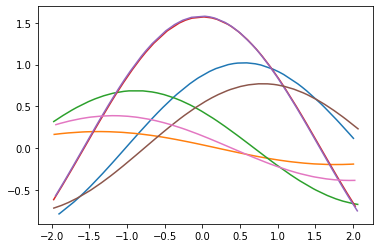

In [128]:
plt.plot(x[0,:],y[0,:])
plt.plot(x[1,:],y[1,:])
plt.plot(x[2,:],y[2,:])
plt.plot(x[3,:],y[3,:])
plt.plot(x[4,:],y[4,:])
plt.plot(x[5,:],y[5,:])
plt.plot(x[6,:],y[6,:])

In [294]:
n_c = random.randint(3, 40)
dataset = data.TensorDataset(x[:n_c], y[:n_c])
batch_size = 16
data_iter =  data.DataLoader(dataset, batch_size, shuffle=True)

In [414]:
class Encoder(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(Encoder, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.Linear1 = torch.nn.Linear(num_inputs, num_hidden)
        self.ReLU = torch.nn.ReLU()
        self.Linear2 = torch.nn.Linear(num_hidden, num_inputs)
        
    def forward(self, x):
        x = x.view(-1, self.num_inputs)
        averagex = torch.mean(x)
        return averagex

In [415]:
# Create and initialize model:
num_inputs, num_hidden, num_outputs = n_c, 2, 10
# Needs to produce context feature: a sum of all features x and y
net = Encoder(num_inputs, num_hidden, num_outputs)

In [416]:
loss = torch.nn.MSELoss()
lr = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr)

In [420]:
def train(net, train_iter, loss, optimizer, epochs):
    for epoch in range(epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
#             l.backward()
            optimizer.step()
        print(f'epoch {epoch + 1}, 'f'loss: {mu.evaluate_loss(net, train_iter, loss):f}')

In [421]:
train(net, data_iter, loss, optimizer, 5)

epoch 1, loss: 0.399952
epoch 2, loss: 0.399952
epoch 3, loss: 0.399952
epoch 4, loss: 0.399952
epoch 5, loss: 0.399952
